In [1]:
# set work dir
import os
os.chdir("../")

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scienceplots
plt.style.reload_library()
plt.style.use("science")
#from matplotlib import rc
#rc("text", usetex=False)
from matplotlib import ticker
import tol_colors as tc

In [3]:
params = [0.0, 1e-3, 1e-2, 1e-1, 1e0, 1e1]

In [4]:
def lighten(color, amount=0.9):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = np.array(colorsys.rgb_to_hls(*mc.to_rgb(c)))
    return colorsys.hls_to_rgb(c[0],1-amount * (1-c[1]),c[2])

In [5]:
def drawPlot(params, n, d, e, reg):
    regrets, mses = getRow(params, n, d, e, reg)
    # color map
    cset =  tc.tol_cset('light')
    cmap = tc.tol_cmap("rainbow_discrete")(np.linspace(0, 1, 22))
    colors = [cset.mint, cset.pink, cmap[16], cmap[5], cmap[7], cmap[10]]
    for i in range(len(colors)):
        colors[i] = lighten(colors[i])
    # x tick
    x = np.array([i for i in range(len(params))])
    # regret
    fig = plt.figure(figsize=(16, 8))
    # line
    c = colors[2]
    plt.plot(x-0.24, regrets["spo"].mean(), linewidth=2, color=c)
    c = colors[3]
    plt.plot(x, regrets["pfyl"].mean(), linewidth=2, color=c)
    c = colors[4]
    plt.plot(x+0.24, regrets["dbb"].mean(), linewidth=2, color=c)
    # box plot
    #===========================================================================================================================
    c = colors[2]
    bp1 = plt.boxplot(regrets["spo"], 
                      boxprops=dict(facecolor=c, color=c, linewidth=4), 
                      medianprops=dict(color="w", linewidth=2), 
                      whiskerprops=dict(color=c, linewidth=2),
                      capprops=dict(color=c, linewidth=2),
                      flierprops=dict(markeredgecolor=c, marker="o", markersize=5, markeredgewidth=2),
                      patch_artist=True, positions=np.arange(regrets["spo"].shape[1])-0.24, widths=0.04)
    #===========================================================================================================================
    c = colors[3]
    bp2 = plt.boxplot(regrets["pfyl"], 
                      boxprops=dict(facecolor=c, color=c, linewidth=4), 
                      medianprops=dict(color="w", linewidth=2), 
                      whiskerprops=dict(color=c, linewidth=2),
                      capprops=dict(color=c, linewidth=2),
                      flierprops=dict(markeredgecolor=c, marker="o", markersize=5, markeredgewidth=2),
                      patch_artist=True, positions=np.arange(regrets["pfyl"].shape[1]), widths=0.04)
    #===========================================================================================================================
    c = colors[4]
    bp3 = plt.boxplot(regrets["dbb"], 
                      boxprops=dict(facecolor=c, color=c, linewidth=4), 
                      medianprops=dict(color="w", linewidth=2), 
                      whiskerprops=dict(color=c, linewidth=2),
                      capprops=dict(color=c, linewidth=2),
                      flierprops=dict(markeredgecolor=c, marker="o", markersize=5, markeredgewidth=2),
                      patch_artist=True, positions=np.arange(regrets["dbb"].shape[1])+0.24, widths=0.04)
    # vertical line
    plt.axvline(x=0.5, color="k", linestyle="--", linewidth=1, alpha=0.75)
    plt.axvline(x=1.5, color="k", linestyle="--", linewidth=1, alpha=0.75)
    plt.axvline(x=2.5, color="k", linestyle="--", linewidth=1, alpha=0.75)
    plt.axvline(x=3.5, color="k", linestyle="--", linewidth=1, alpha=0.75)
    plt.axvline(x=4.5, color="k", linestyle="--", linewidth=1, alpha=0.75)
    # labels and ticks
    plt.xlim(-0.5, 5.5)
    plt.ylim(0, 0.22)
    plt.xticks(x, labels=params, fontsize=28)
    plt.yticks(fontsize=24)
    if reg == "l1":
        plt.xlabel("L1 Parameter", fontsize=36)
    if reg == "l2":
        plt.xlabel("L2 Parameter", fontsize=36)
    plt.ylabel("Normalized Regret", fontsize=36)
    plt.title("Test Loss on 2D Knapsack\nTraining Set Size = {}, Polynomial Degree = {}, Noise Half−width = {}".
              format(n,d,e),
              fontsize=30)
    plt.legend([bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0]], ["SPO+", "PFYL", "DBB"], fontsize=22, ncol=2, loc=1)
    plt.show()
    fig.savefig("./images/{}-ks-n{}d{}e{}-regret.pdf".format(reg,n,d,int(10*e)), dpi=300)
    # mse
    fig = plt.figure(figsize=(16, 8))
    # line
    c = colors[2]
    plt.plot(x-0.24, mses["spo"].mean(), linewidth=2, color=c)
    c = colors[3]
    plt.plot(x, mses["pfyl"].mean(), linewidth=2, color=c)
    c = colors[4]
    plt.plot(x+0.24, mses["dbb"].mean(), linewidth=2, color=c)
    # boxplot
    #===========================================================================================================================
    c = colors[2]
    bp1 = plt.boxplot(mses["spo"], 
                      boxprops=dict(facecolor=c, color=c, linewidth=4), 
                      medianprops=dict(color="w", linewidth=2), 
                      whiskerprops=dict(color=c, linewidth=2),
                      capprops=dict(color=c, linewidth=2),
                      flierprops=dict(markeredgecolor=c, marker="o", markersize=5, markeredgewidth=2),
                      patch_artist=True, positions=np.arange(mses["spo"].shape[1])-0.24, widths=0.04)
    #===========================================================================================================================
    c = colors[3]
    bp2 = plt.boxplot(mses["pfyl"], 
                      boxprops=dict(facecolor=c, color=c, linewidth=4), 
                      medianprops=dict(color="w", linewidth=2), 
                      whiskerprops=dict(color=c, linewidth=2),
                      capprops=dict(color=c, linewidth=2),
                      flierprops=dict(markeredgecolor=c, marker="o", markersize=5, markeredgewidth=2),
                      patch_artist=True, positions=np.arange(mses["pfyl"].shape[1]), widths=0.04)
    #===========================================================================================================================
    c = colors[4]
    bp3 = plt.boxplot(mses["dbb"], 
                      boxprops=dict(facecolor=c, color=c, linewidth=4), 
                      medianprops=dict(color="w", linewidth=2), 
                      whiskerprops=dict(color=c, linewidth=2),
                      capprops=dict(color=c, linewidth=2),
                      flierprops=dict(markeredgecolor=c, marker="o", markersize=5, markeredgewidth=2),
                      patch_artist=True, positions=np.arange(mses["dbb"].shape[1])+0.24, widths=0.04)
    # vertical line
    plt.axvline(x=0.5, color="k", linestyle="--", linewidth=1, alpha=0.75)
    plt.axvline(x=1.5, color="k", linestyle="--", linewidth=1, alpha=0.75)
    plt.axvline(x=2.5, color="k", linestyle="--", linewidth=1, alpha=0.75)
    plt.axvline(x=3.5, color="k", linestyle="--", linewidth=1, alpha=0.75)
    plt.axvline(x=4.5, color="k", linestyle="--", linewidth=1, alpha=0.75)
    # labels and ticks
    plt.xlim(-0.5, 5.5)
    plt.ylim(0, 90)
    plt.xticks(x, labels=params, fontsize=28)
    plt.yticks(fontsize=24)
    if reg == "l1":
        plt.xlabel("L1 Parameter", fontsize=36)
    if reg == "l2":
        plt.xlabel("L2 Parameter", fontsize=36)
    plt.ylabel("MSE", fontsize=36)
    plt.title("Test Loss on 2D Knapsack\nTraining Set Size = {}, Polynomial Degree = {}, Noise Half−width = {}".
              format(n,d,e),
              fontsize=30)
    plt.legend([bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0]], ["SPO+", "PFYL", "DBB"], fontsize=22, ncol=2, loc=1)
    plt.show()
    fig.savefig("./images/{}-ks-n{}d{}e{}-mse.pdf".format(reg,n,d,int(10*e)), dpi=300)

In [6]:
def getRow(grids, n, d, e, reg):
    regrets = {"spo":pd.DataFrame(), "pfyl":pd.DataFrame(), "dbb":pd.DataFrame()}
    mses = {"spo":pd.DataFrame(), "pfyl":pd.DataFrame(), "dbb":pd.DataFrame()}
    for param in params:
        r, s = getData(param, n, d, e, reg)
        for m in regrets:
            regrets[m][param] = r[m]
            mses[m][param] = s[m]
    return regrets, mses

In [7]:
def getData(param, n, d, e, reg):
    # dir
    dir_name = "./res/ks/i32d2c20/gurobi"
    file_name = {}
    if reg == "l1":
        file_name["lr"]   = "n{}p5-d{}-e{}_2s-lr.csv".format(n,d,e)
        file_name["spo"]  = "n{}p5-d{}-e{}_spo_lr_adam0.01_bs32_l1{}l20.0_c32.csv".format(n,d,e,param)
        file_name["pfyl"] = "n{}p5-d{}-e{}_pfyl_lr_adam0.01_bs32_l1{}l20.0_c32-samp1eps1.0.csv".format(n,d,e,param)
        file_name["dbb"]  = "n{}p5-d{}-e{}_dbb_lr_adam0.1_bs32_l1{}l20.0_c32-lamb10.csv".format(n,d,e,param)
    if reg == "l2":
        file_name["lr"]   = "n{}p5-d{}-e{}_2s-lr.csv".format(n,d,e)
        file_name["spo"]  = "n{}p5-d{}-e{}_spo_lr_adam0.01_bs32_l10.0l2{}_c32.csv".format(n,d,e,param)
        file_name["pfyl"] = "n{}p5-d{}-e{}_pfyl_lr_adam0.01_bs32_l10.0l2{}_c32-samp1eps1.0.csv".format(n,d,e,param)
        file_name["dbb"]  = "n{}p5-d{}-e{}_dbb_lr_adam0.1_bs32_l10.0l2{}_c32-lamb10.csv".format(n,d,e,param)
    # load data
    regret, mse = {}, {}
    for m, f in file_name.items():
        df = pd.read_csv(dir_name + "/" + f)
        regret[m] = df["Unamb SPO"]
        mse[m] = df["MSE"]
    return regret, mse

## Deg = 1

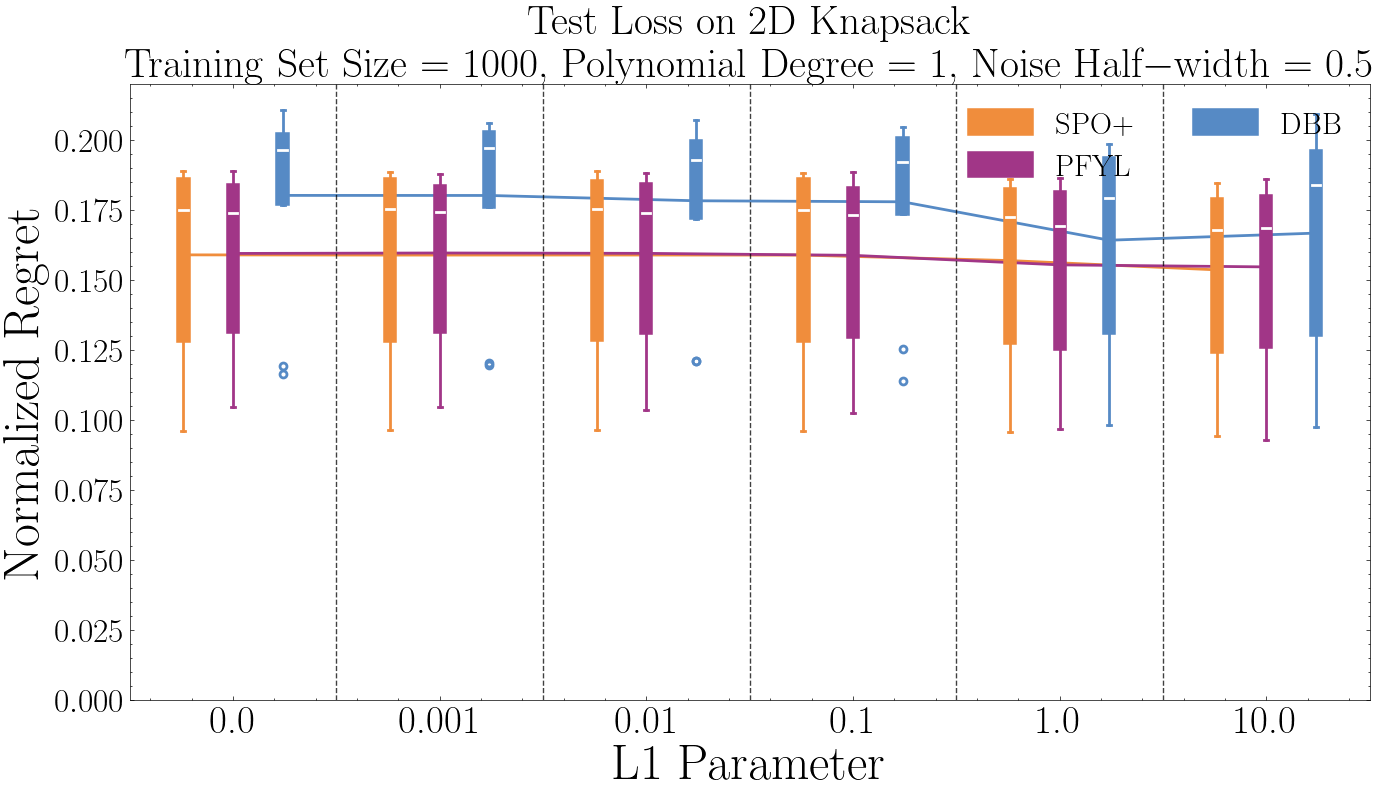

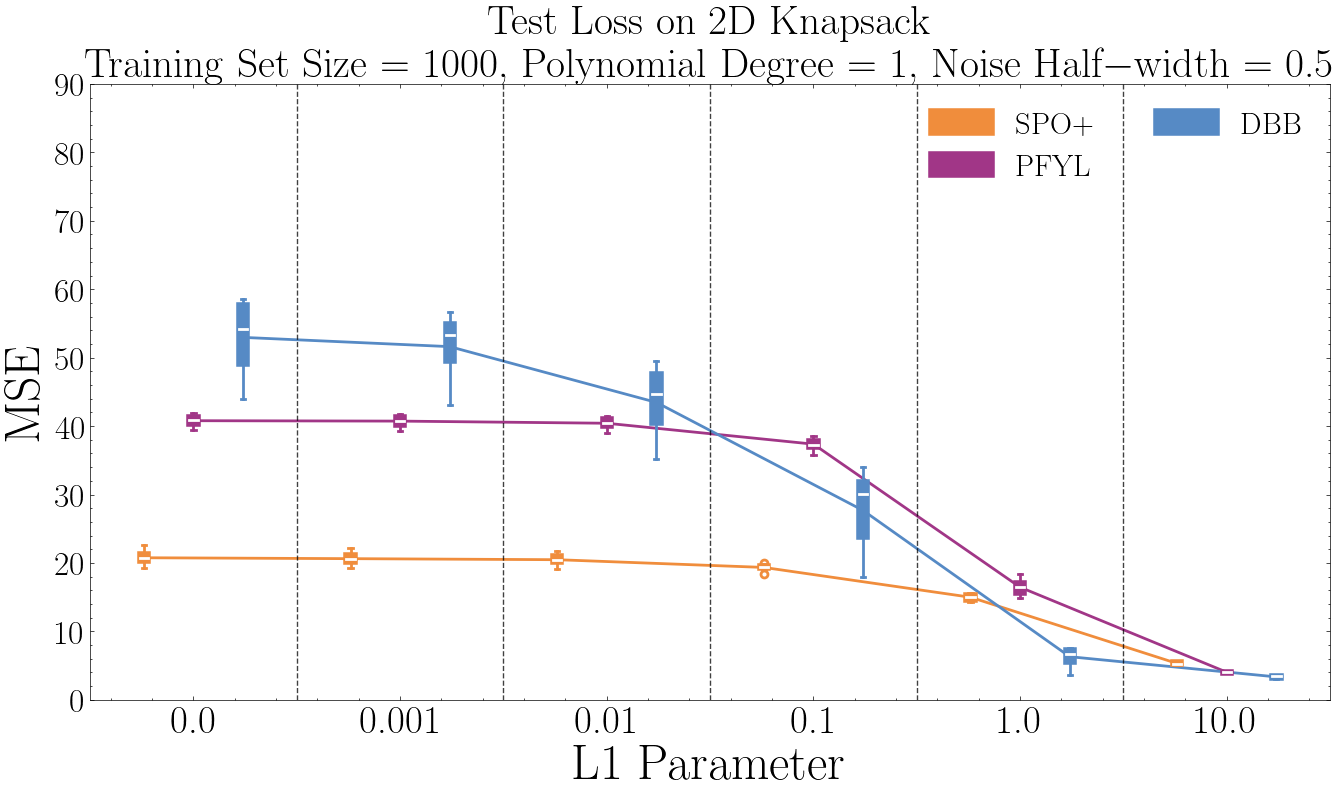

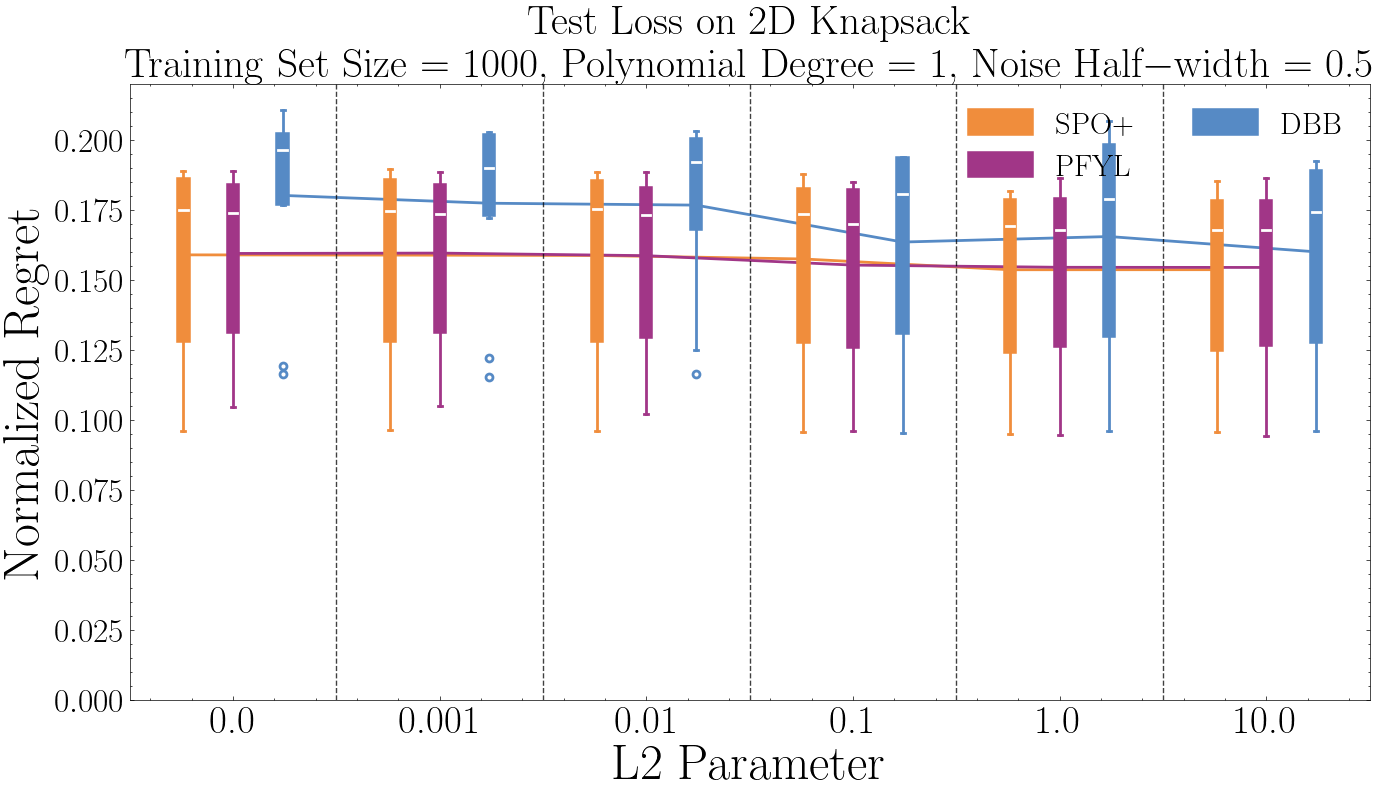

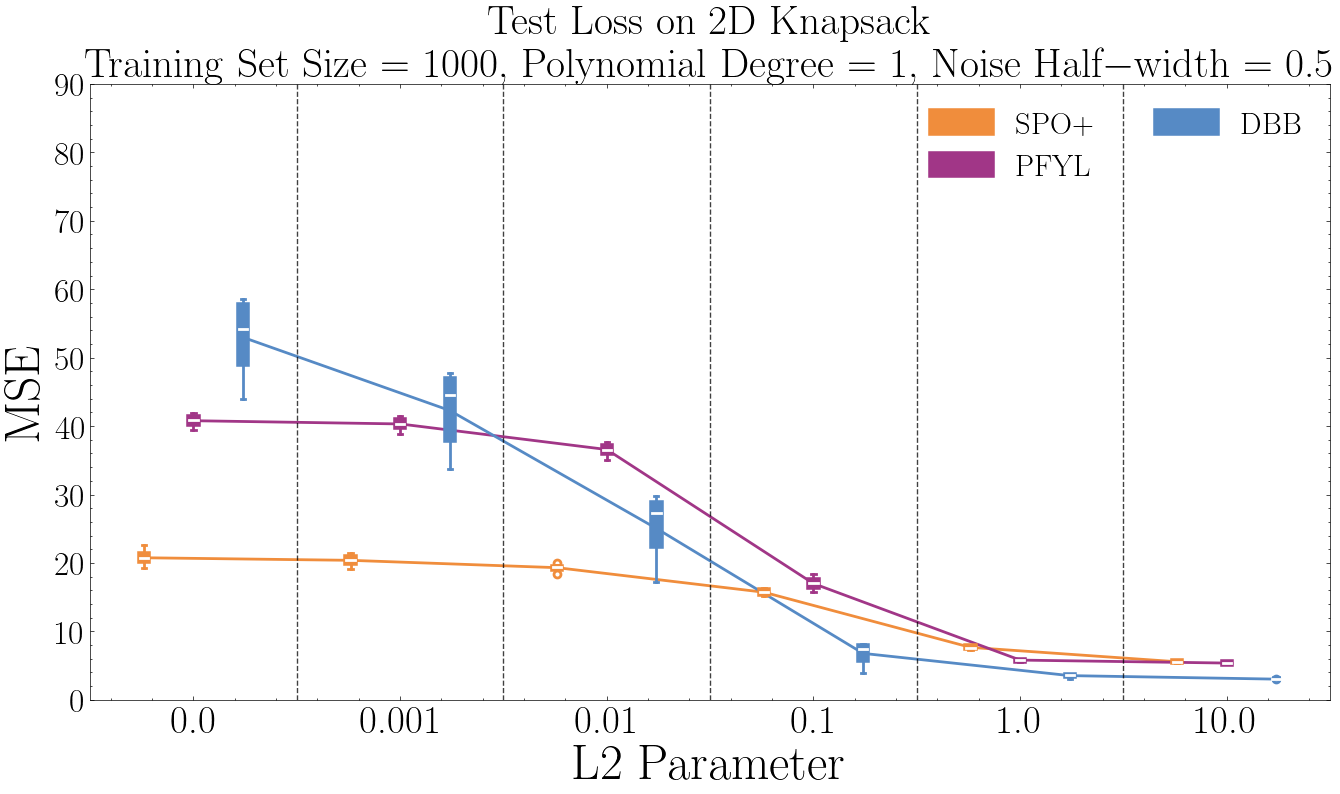

In [8]:
n = 1000
d = 1
e = 0.5
drawPlot(params, n, d, e, reg="l1")
drawPlot(params, n, d, e, reg="l2")

## Deg = 2 

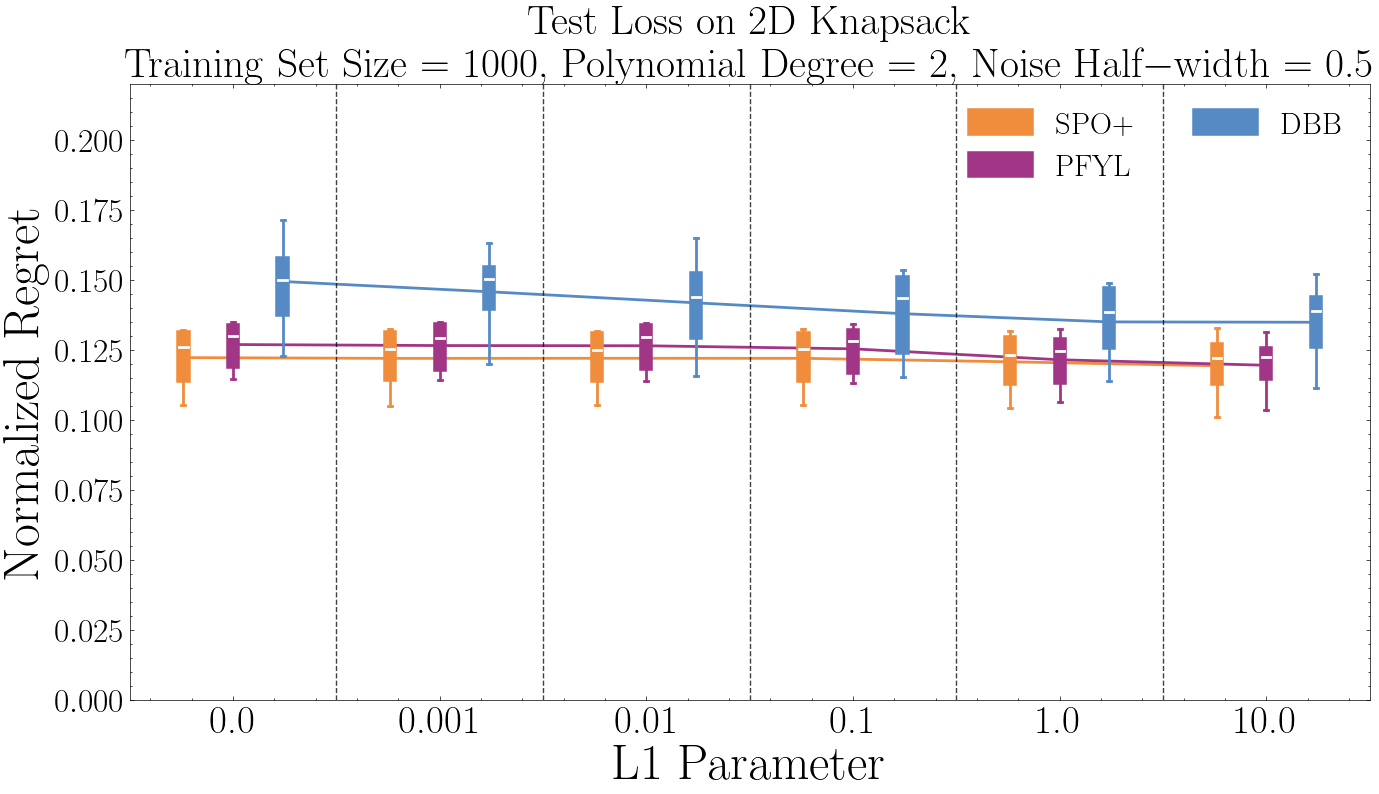

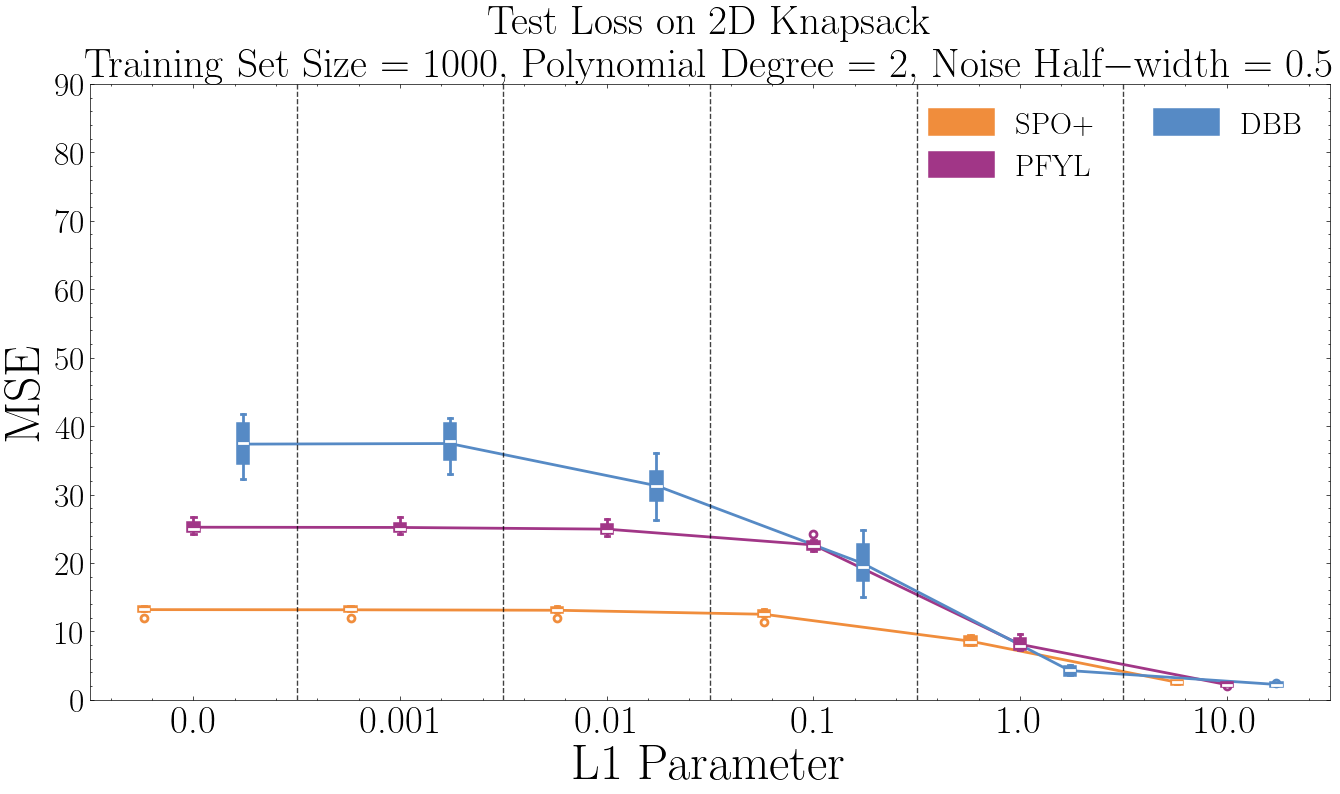

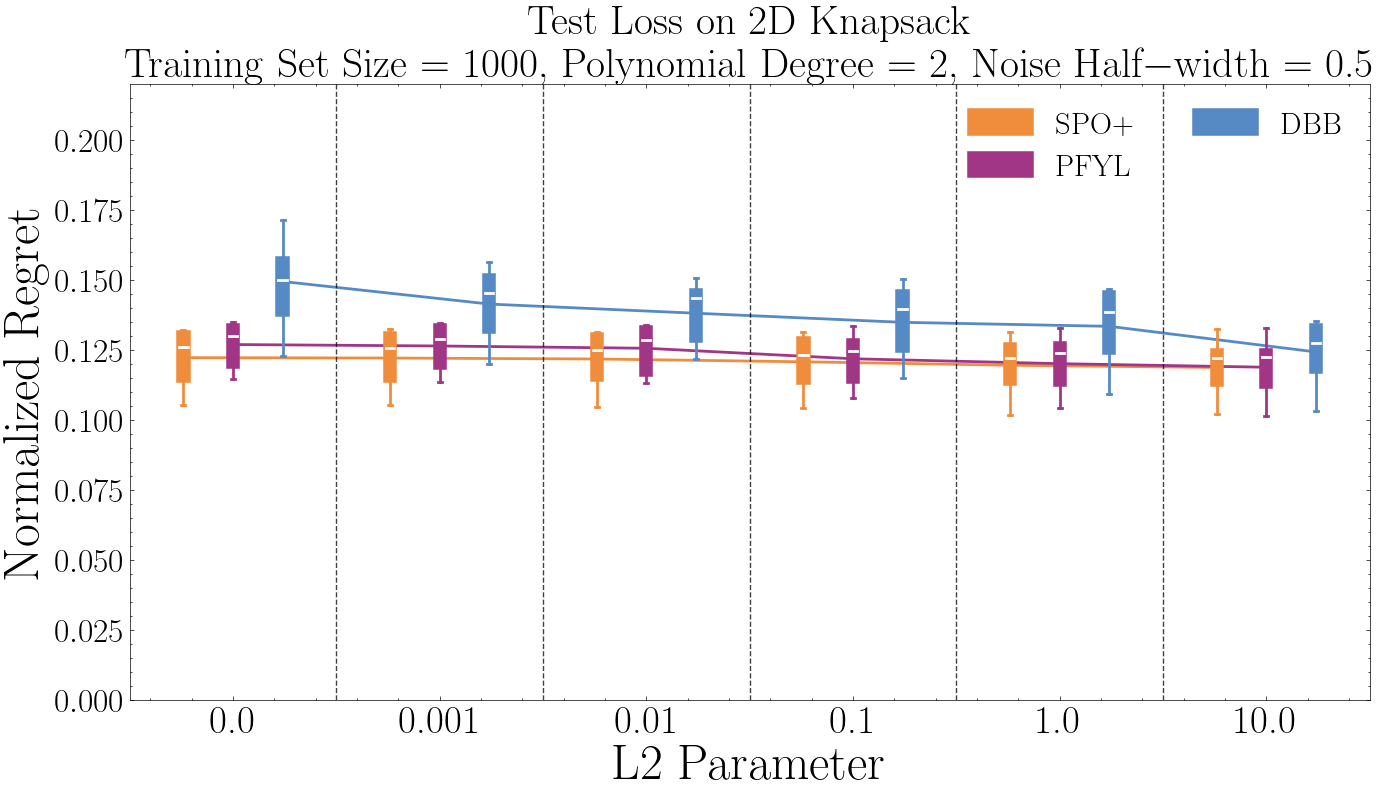

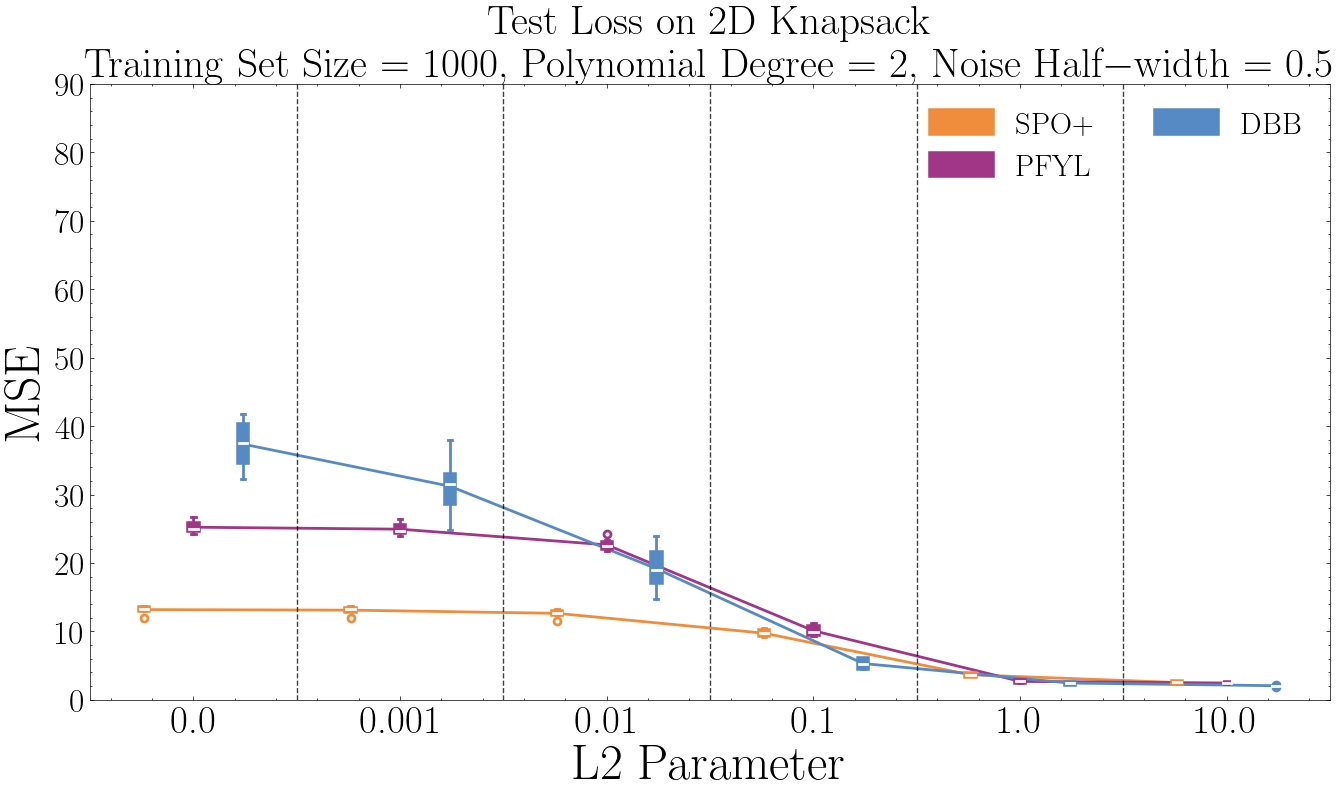

In [9]:
n = 1000
d = 2
e = 0.5
drawPlot(params, n, d, e, reg="l1")
drawPlot(params, n, d, e, reg="l2")

## Deg = 4 

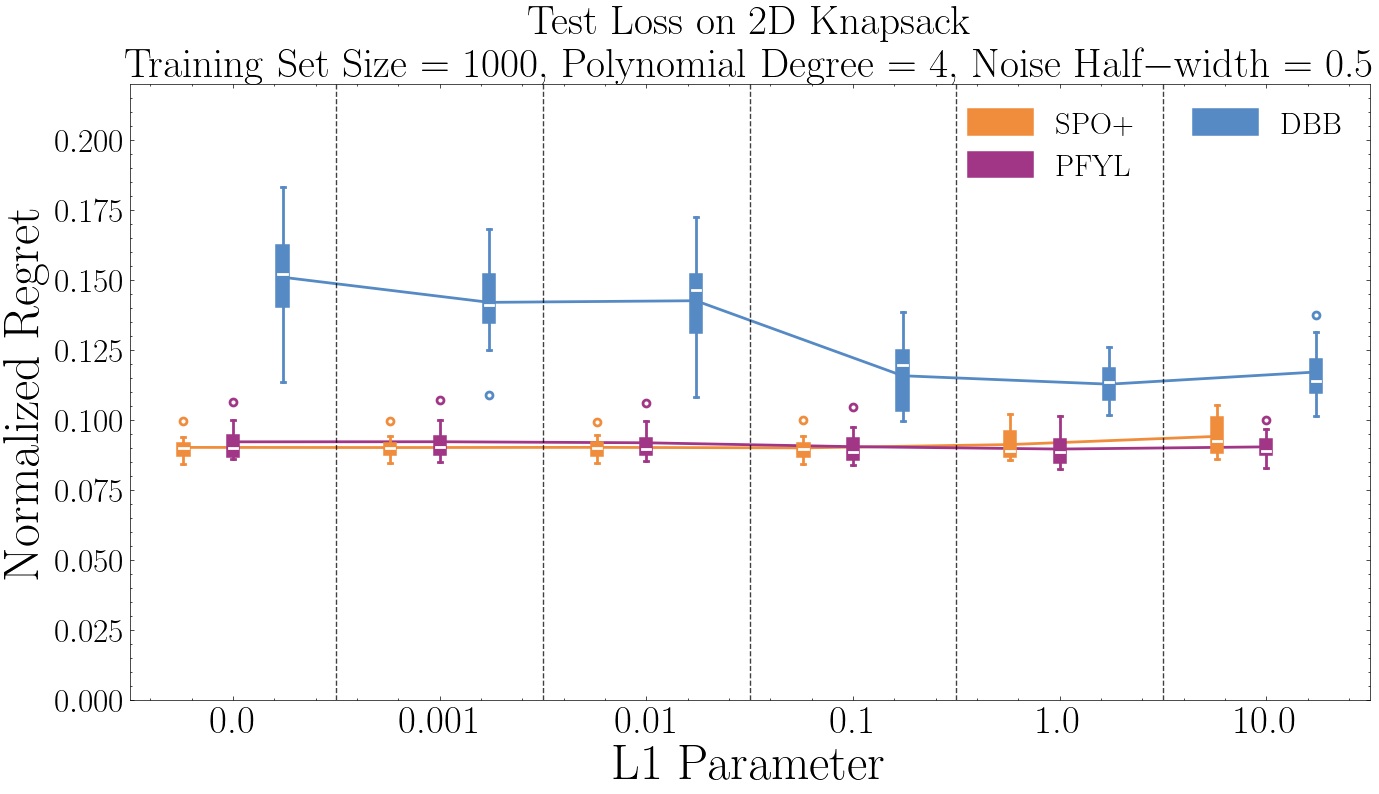

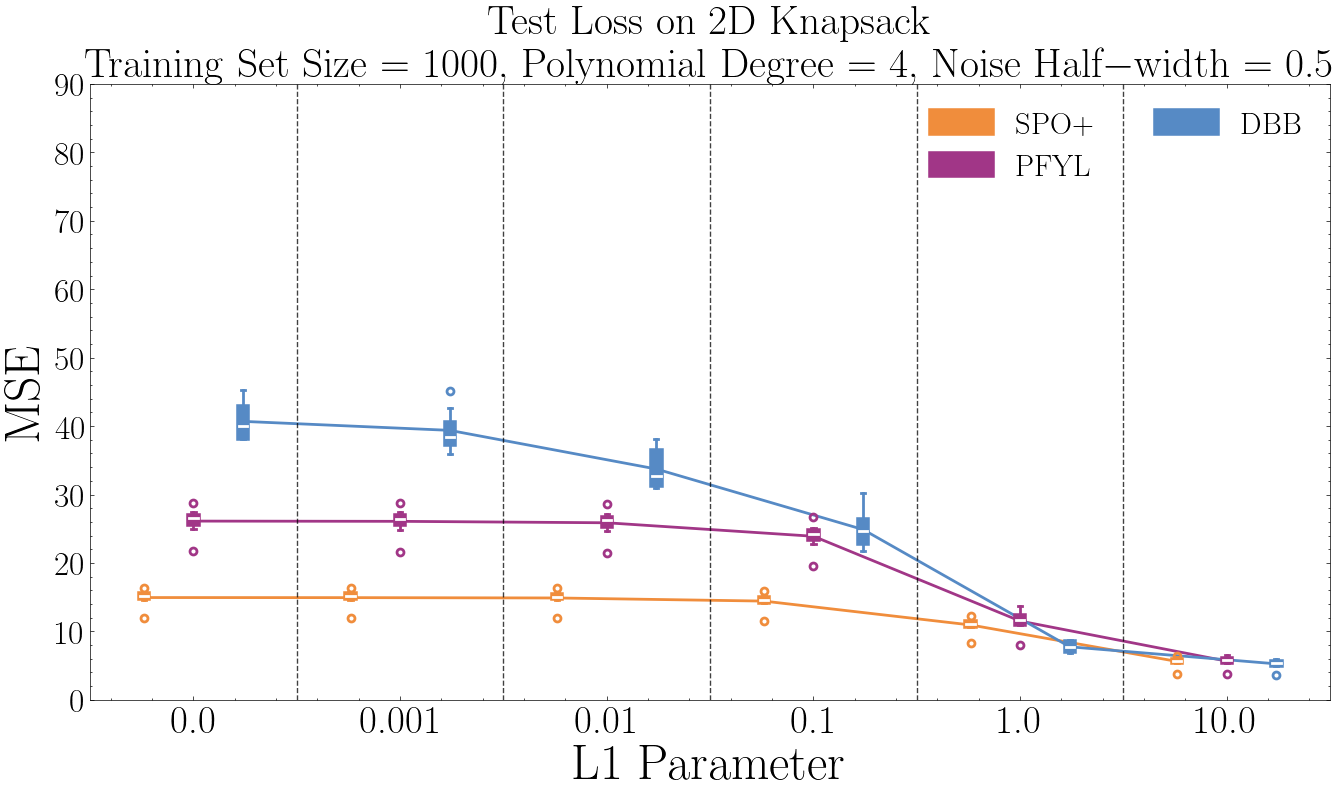

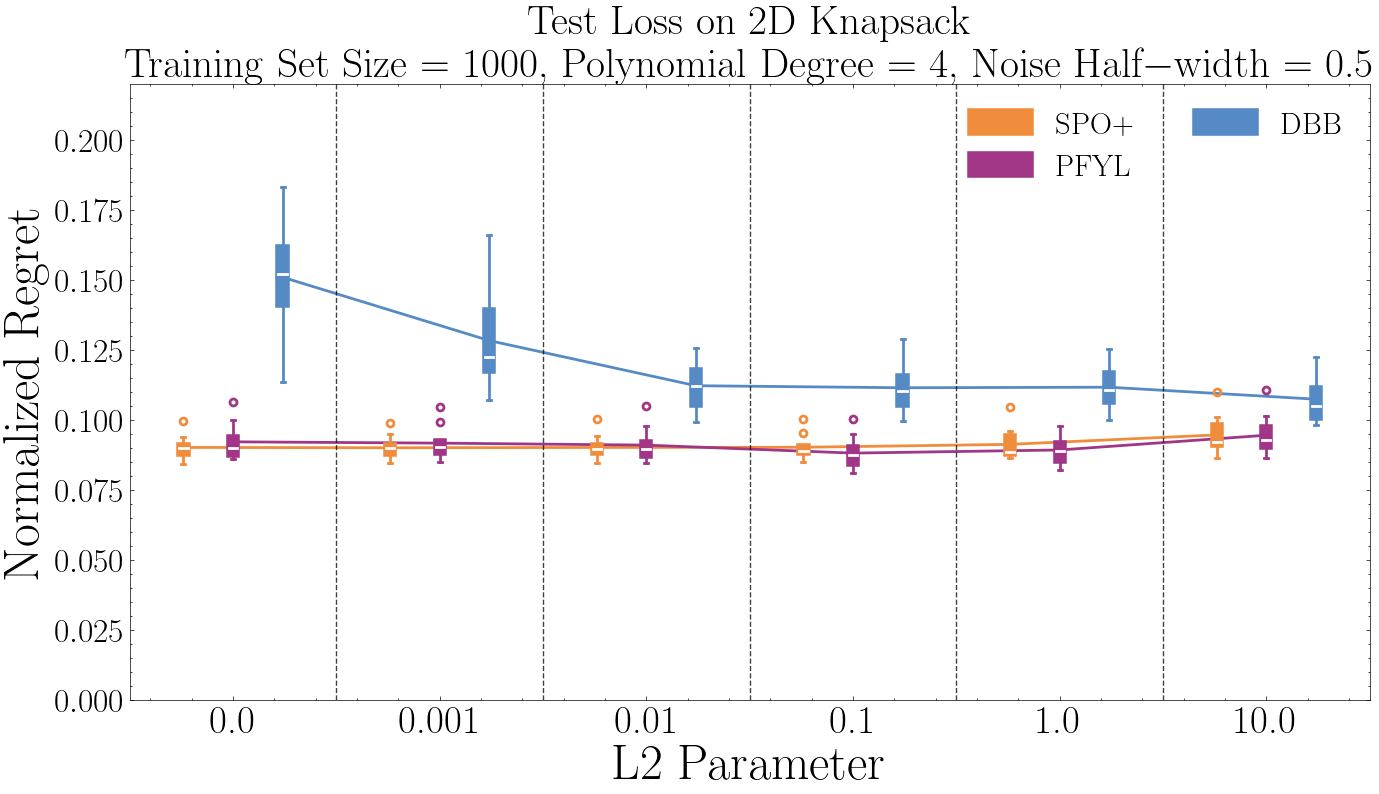

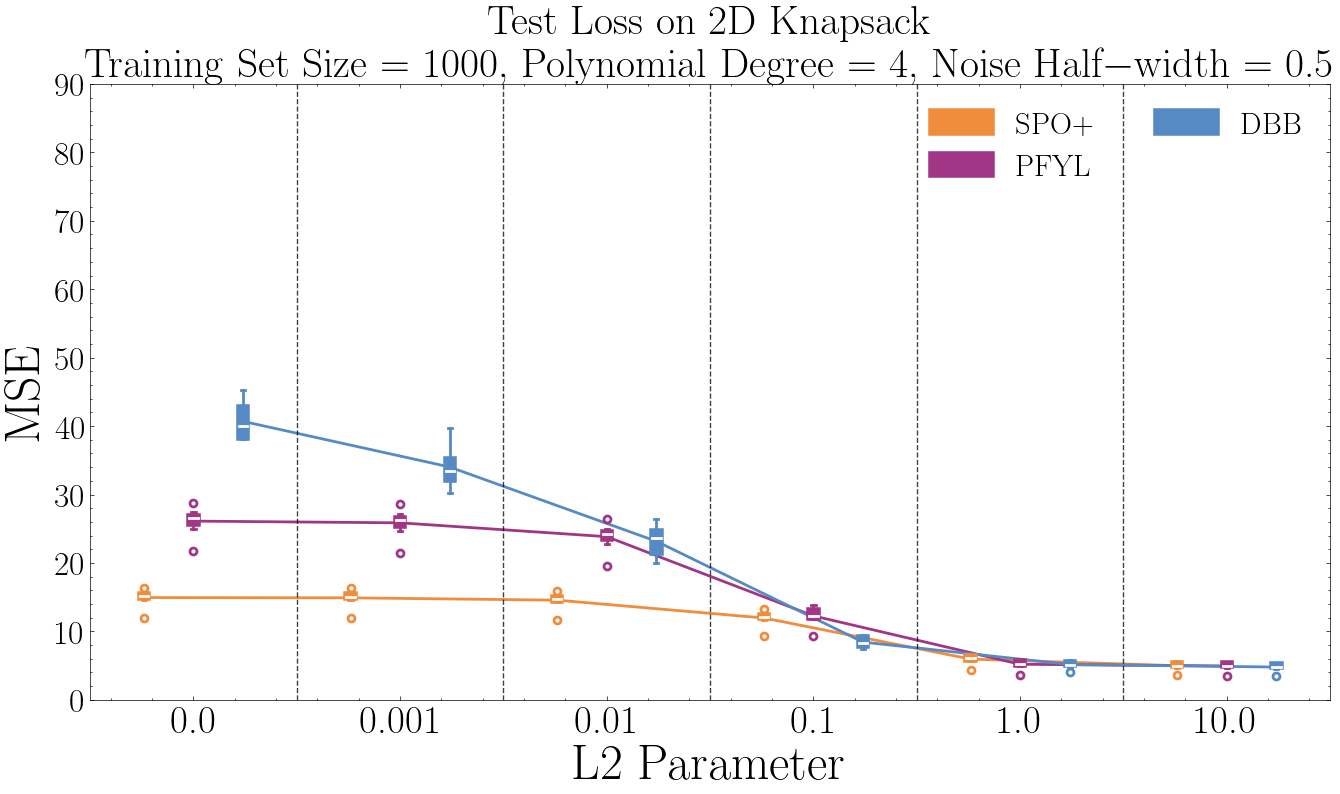

In [10]:
n = 1000
d = 4
e = 0.5
drawPlot(params, n, d, e, reg="l1")
drawPlot(params, n, d, e, reg="l2")

## Deg = 6

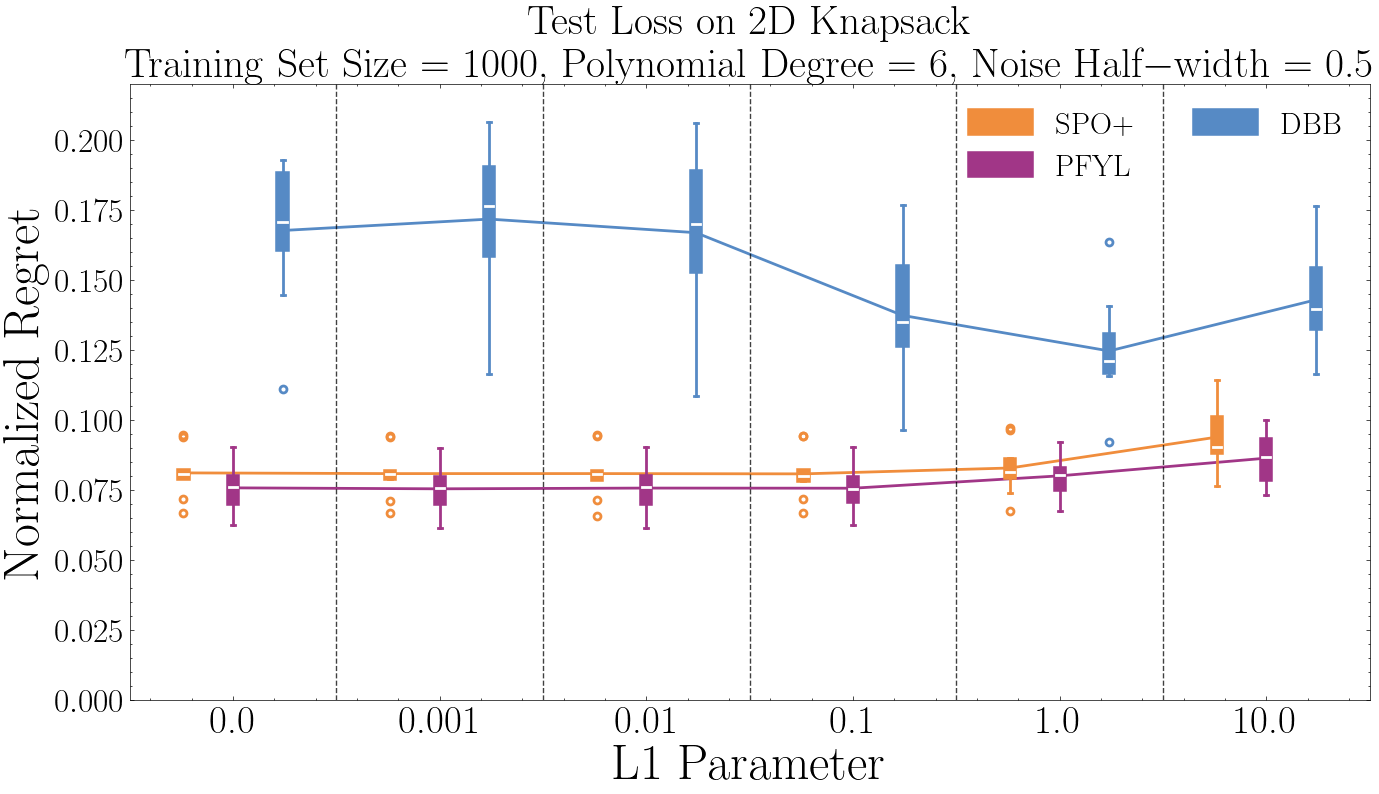

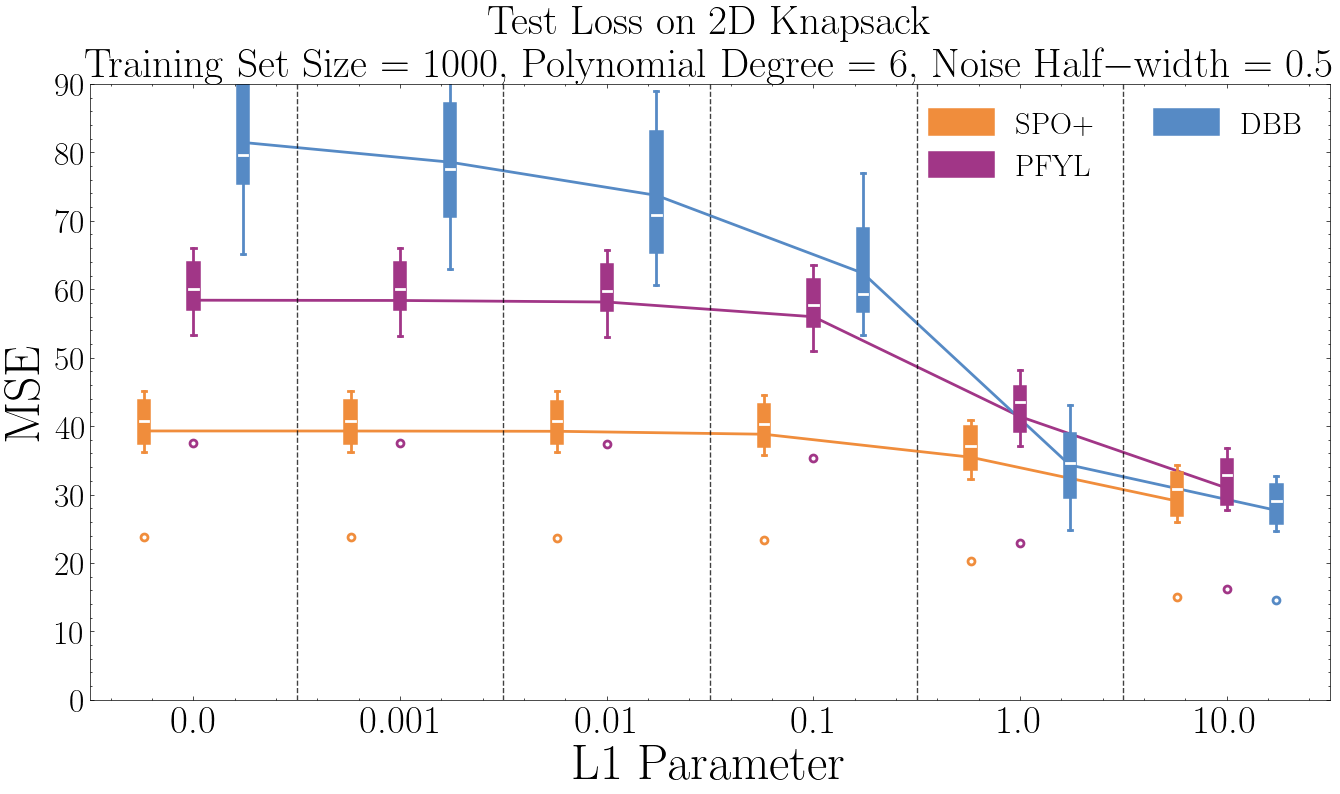

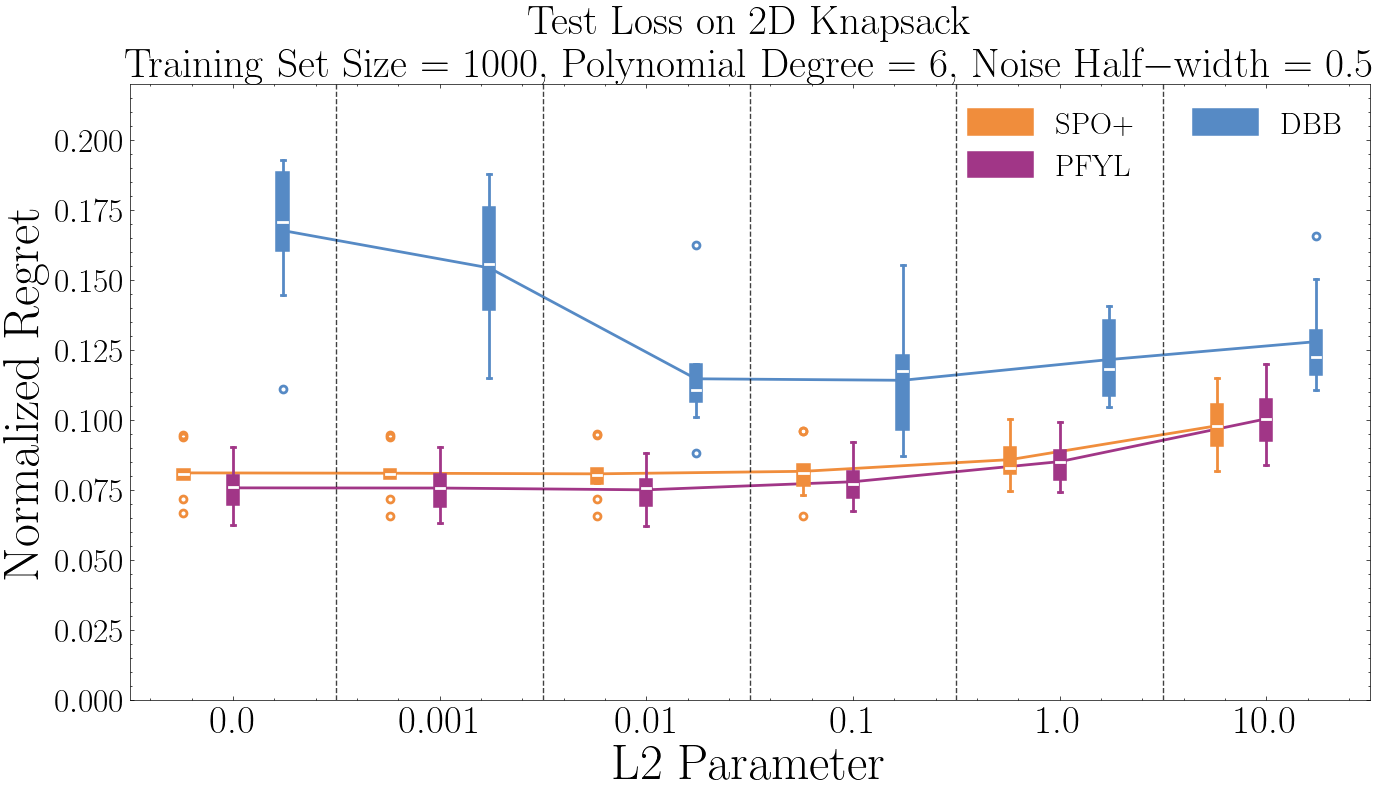

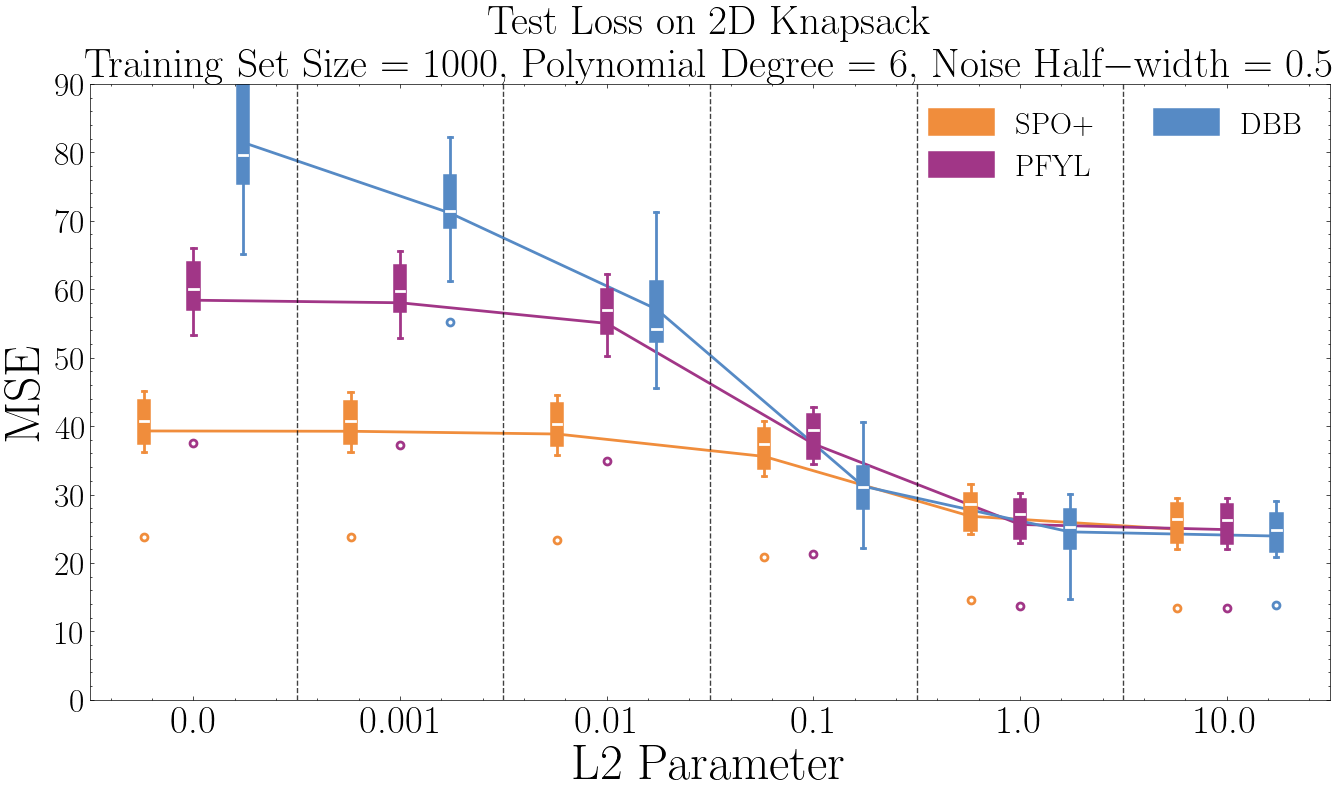

In [11]:
n = 1000
d = 6
e = 0.5
drawPlot(params, n, d, e, reg="l1")
drawPlot(params, n, d, e, reg="l2")